# Exploring HGCal

Let's take a look at some hgcal data.  First some simple visualizations...

In [1]:
#imports and setup
%matplotlib inline
%cd /home/naodell/work/CMS/hgcal/hgcal_analysis''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import plotly.plotly as plotly
import plotly.graph_objs as go
from plotly.graph_objs import Surface, Mesh3d
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
    
from scripts.helpers import eta_to_theta, propagate_to_face, assign_phi

/home/naodell/work/CMS/hgcal/hgcal_analysis


In [2]:
# get the rechits and apply some cuts
event_data = pd.read_csv('data/pions/rechits.csv', names=['evt', 'x', 'y', 'z', 't', 'e'])
event_data = event_data.query('z > 0. and evt == 3')

# add some additional vars
event_data['r'] = np.sqrt(event_data.x**2 + event_data.y**2)
event_data['phi'] = np.arctan(np.abs(event_data.y/event_data.x)) 
assign_phi(event_data) # needed to correctly map phi onto 0 to 2pi

# get the gen particles 
gen_data = pd.read_csv('data/pions/genparticles.csv', names=['evt', 'pdgid', 'eta', 'phi', 'pt', 'e'])
gen_data['theta'] = 2*np.arctan(np.exp(-gen_data.eta))
gen_data = gen_data.query('theta > 0. and evt == 3')

In [ ]:
#plt.yscale('log')
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True, facecolor='white')
axes[0].hist(event_data.e, range=(0., 2.), bins=50, histtype='step', lw=2)
axes[0].set_xlabel('rechit energy')
axes[0].set_ylabel('hits')
axes[0].set_title('')
axes[0].set_xlim([0., 2.])

axes[1].hist(event_data.t, range=(0.99, 1.15), bins=20, histtype='step', lw=2)
axes[1].set_xlabel('rechit time')
axes[1].set_ylabel('hits')
axes[1].set_title('')
axes[1].set_xlim([0.99, 1.15])

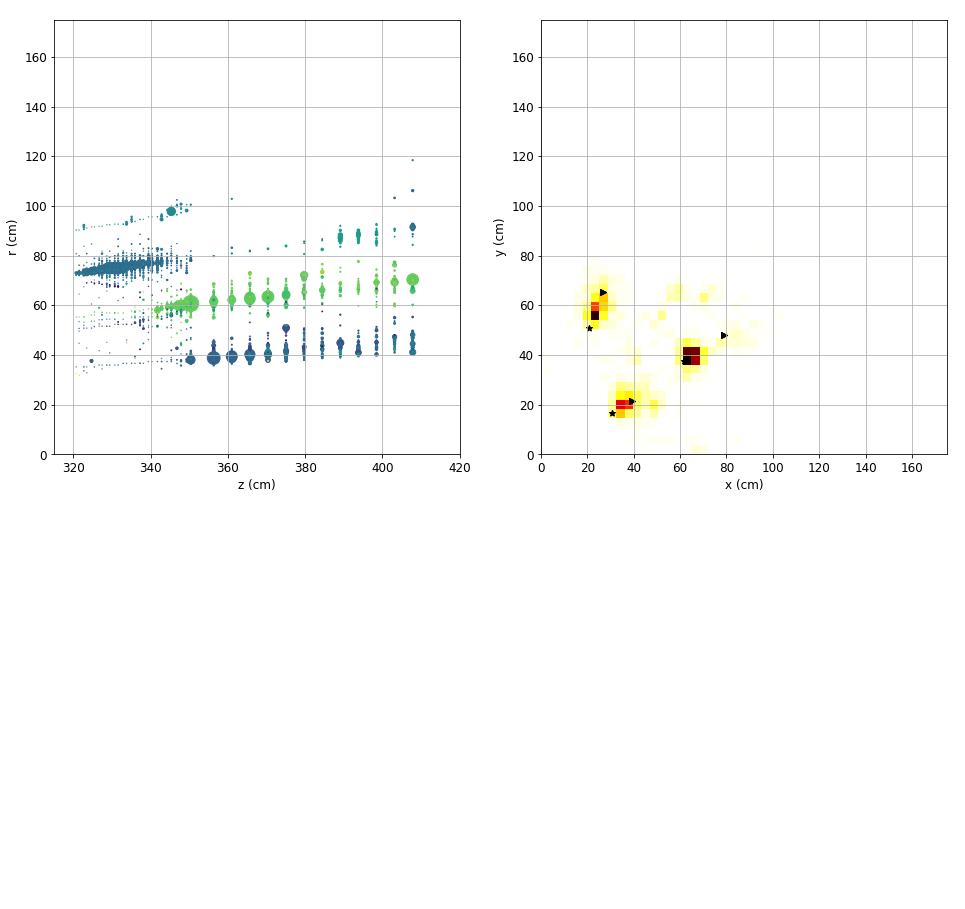

In [4]:
scan_data = event_data.query('np.sqrt(xy > 0. and 0. < phi < {0}/2'.format(np.pi))
phi_cscale = scan_data.phi/(2*np.pi)

gen_face_position = np.array([propagate_to_face(p.theta, p.phi, p.pt, 3.2, 0.14) for i,p in gen_data.iterrows()])
gen_tail_position = np.array([propagate_to_face(p.theta, p.phi, p.pt, 4.1, 0.14) for i,p in gen_data.iterrows()])

fig, axes = plt.subplots(1, 2, figsize=(16,8), facecolor='white')
axes[0].scatter(scan_data.z, np.sign(scan_data.y)*scan_data.r, s=20*scan_data.e, c=phi_cscale, cmap='viridis')
    
axes[0].set_xlabel('z (cm)')
axes[0].set_ylabel('r (cm)')
axes[0].set_xlim([315., 420.])
axes[0].set_ylim([0., 175.])

axes[1].scatter(100.*gen_face_position[:,0], 100.*gen_face_position[:,1], marker='*', c='k')
axes[1].scatter(100.*gen_tail_position[:,0], 100.*gen_tail_position[:,1], marker='>', c='k')
axes[1].hist2d(scan_data.x, scan_data.y, bins=100, range=[[-180, 180], [-180, 180]], cmap='hot_r')
axes[1].set_xlabel('x (cm)')
axes[1].set_ylabel('y (cm)')
axes[1].set_xlim([0., 175.])
axes[1].set_ylim([0., 175.])
plt.show()

In [ ]:
# plot the rechits (requires plotly and an internet connection)
sd     = event_data.query('e > 0.1')
cscale = sd.e/(sd.e.max() - sd.e.min())
trace1 = go.Scatter3d(x=sd.x, y=sd.z, z=sd.y, mode='markers',
                      marker=dict(
                      size=1,
                      color=cscale,           # set color to an array/list of desired values
                      colorscale='Inferno_r',   # choose a colorscale
                      reversescale=True,
                      opacity=1.
                      )
                    )


# plot detector elements
theta  = np.linspace(0., 2*np.pi, 13)
r1, r2 = 32.1, 164.5
detz   = np.sort(sd.z.unique())
detz   = detz[np.abs(detz) < 350.]
zz     = [2*[z*np.ones(theta.size),] for z in detz]
X, Y   = [r1*np.cos(theta), r2*np.cos(theta)], [r1*np.sin(theta), r2*np.sin(theta)]
c      = [[0, 'rgb(0, 50, 100)'], [1, 'rgb(0, 50, 100)']]
ee     = [dict(x=X, y=z, z=Y, 
               colorscale = c, 
               showscale  = False, 
               opacity    = 0.3, 
               type       = 'surface') 
          for z in zz]

#trace = go.Scatter3d()
#    x=X, y=zz[0], z=Y,
#    marker=dict(
#        size=4,
#        color='rgb(255,255,255)',
#        #colorscale='Viridis',
#    ),
#    line=dict(
#        color='#1f77b4',
#        width=1
#    )
#)


layout = go.Layout(margin = dict(l=0, r=0, b=0, t=0),
                   scene  = dict(xaxis=dict(title='x (cm)'), 
                                 yaxis=dict(title='z (cm)'), 
                                 zaxis=dict(title='y (cm)')
                                )
                  )
data = ee + [trace1]
fig = dict(data=data, layout=layout)
plotly.iplot(fig, autosize=False, width=1000, height=1000, filename='pions')

In [ ]:
#from skimage.feature import blob_doh
#blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)